In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Input, Flatten
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2024-08-04 21:26:45.241688: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-04 21:26:45.448494: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-04 21:26:45.666290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 21:26:45.835693: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 21:26:45.884896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 21:26:46.047276: I tensorflow/core/platform/cpu_feature_gu

In [2]:
import os as os
import numpy as np
from PIL import Image

In [6]:
def label_index(img_name):
    img_num = img_name.split('.')[0]
    return int(img_num)

def load_and_preprocess_image(filepath, target_size=(64, 128, 1)):
    image = load_img(filepath, color_mode='grayscale', target_size=target_size)
    return np.array(image)

def split_image(image_arr, num_splits=6):
    height, width = image_arr.shape
    split_height = width // num_splits
    splits = [image_arr[:, i*split_height:(i+1)*split_height].copy() for i in range(num_splits)]
    npsplits =  [np.array(split) for split in splits]

    return npsplits

def read_images(dir_name, limit=10000):
    img_files = sorted(os.listdir(f"dados/CAPTCHA-10k/{dir_name}"))
    imgs = []
    it = 0
    for file in img_files:
        it += 1
        if it > limit:
            break
        imgs += split_image(load_and_preprocess_image(f'dados/CAPTCHA-10k/{dir_name}/{file}'))

    label_files = sorted(os.listdir("dados/CAPTCHA-10k/labels10k"))
    init, end = label_index(img_files[0])-1, label_index(img_files[-1])
    labels = []
    drop_indices = []
    it = 0
    for file in label_files[init:end]:
        it += 1
        if it > limit:
            break
        with open(f"dados/CAPTCHA-10k/labels10k/{file}", "r") as f:
            label = f.read().strip()
            if len(label) > 6:
                print(f'bigger captcha: {label} in img {file}')
                drop_indices.append(it-1) # remove captchas with more than 6 chars
                continue
        for char in label:
            coding = np.zeros(36)
            if char.isdigit():
                coding[int(char)+26] = 1
            else:
                coding[ord(char)-65] = 1
            labels.append(coding)

    for i in range(len(drop_indices)):
        if i > 0:
            i -= 6
        for j in range(6):
            imgs.pop(i+j)
    return np.array(imgs), np.array(labels)

In [66]:
train_x, train_y = read_images('treinamento', 5000)


In [71]:
inputs = Input(shape=(64, 21,1))

# Convolutional Layers
x = Conv2D(128, (3, 3), padding='same', activation='relu')(inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten Layer
x = Flatten()(x)

# Dense Layers
x = Dense(128, activation='relu')(x)
outputs = Dense(36, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 21, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 21, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 11, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       655,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,204 (2.80 MB)

 Trainable params: 735,204 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
history = model.fit(train_x, train_y, epochs=10, batch_size=10)

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - accuracy: 0.5295 - loss: 2.2104
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - accuracy: 0.8539 - loss: 0.4311
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.8791 - loss: 0.3503
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - accuracy: 0.8963 - loss: 0.2941
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.9038 - loss: 0.2690
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - accuracy: 0.9096 - loss: 0.2464
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.9230 - loss: 0.2183
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - accuracy: 0.9265 - loss: 0.2030
Epoch 9/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - accuracy: 0.9317 - loss: 0.1919
Epoch 10/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - accuracy: 0.9344 - loss: 0.1850


In [73]:
test_x, test_y = read_images('teste', 1000)
model.evaluate(test_x, test_y)

bigger captcha: WMB8YMN in img 009067.txt
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6666 - loss: 7.7138


[2.4860525131225586, 0.8103103041648865]

In [75]:
pred_y = model.predict(test_x)
pred_y

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


array([[5.0700928e-06, 4.6289690e-05, 8.2240455e-05, ..., 4.9767859e-06,
        7.0559099e-02, 1.0027340e-05],
       [6.9825563e-09, 1.1273826e-08, 1.2554798e-01, ..., 1.8617172e-11,
        1.5502622e-04, 5.9582055e-09],
       [2.1510531e-16, 2.7859889e-10, 5.7846911e-17, ..., 1.4862538e-11,
        1.2753286e-14, 3.5049789e-33],
       ...,
       [3.8420708e-16, 1.7153005e-16, 2.4101647e-24, ..., 2.0952583e-16,
        2.9547631e-10, 2.0799254e-19],
       [3.6752736e-16, 1.9677040e-17, 4.8590447e-21, ..., 5.6621058e-10,
        9.8438798e-15, 1.5283854e-33],
       [3.4742112e-13, 8.5561014e-10, 9.3961523e-12, ..., 4.0353815e-19,
        1.1209735e-05, 3.6452656e-16]], dtype=float32)

In [86]:
test_list = []
for v in test_y:
    l = list(v)
    i = l.index(max(l))
    if i < 26:
        c = chr(i + 65)
    else:
        c = str(i - 26)
    test_list.append(c)

In [83]:
pred_list = []
for v in pred_y:
    l = list(v)
    i = l.index(max(l))
    if i < 26:
        c = chr(i + 65)
    else:
        c = str(i - 26)
    pred_list.append(c)

In [96]:
n_hits_dict = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
for i in range(len(test_list)//6):
    hits = 0
    for j in range(6):
        if test_list[i*6 + j] == pred_list[i*6 + j]:
            hits += 1
    if hits == 4:
        print(i)
    n_hits_dict[hits] += 1

69
76
77
82
86
95
104
105
111
116
122
123
131
140
149
158
164
165
170
172
176
181
200
201
204
206
210
213
225
228
230
236
239
241
256
258
280
287
296
308
313
317
322
327
330
333
337
338
353
354
369
370
374
376
381
390
397
398
403
415
429
435
451
457
459
468
469
471
473
474
478
482
489
490
494
506
510
513
519
520
523
524
527
535
539
544
552
557
598
603
609
622
623
642
646
648
654
657
662
663
664
668
686
707
711
716
732
733
737
744
746
749
751
752
755
758
760
768
774
791
794
796
800
829
831
833
836
844
849
852
861
870
873
875
892
900
902
916
919
923
924
931
936
938
939
941
951
965
976
980
983
987
988


In [90]:
n_hits_dict

{0: 54, 1: 11, 2: 6, 3: 17, 4: 153, 5: 377, 6: 381}

['9', 'D', 'H', 'M', 'S', 'D']


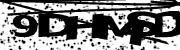

In [93]:
print(pred_list[66*6:66*6 + 6])
image = Image.open(f"dados/CAPTCHA-10k/teste/00"+str(67+9001)+".jpg").convert('L')
Image.fromarray(np.array(image), 'L')

['L', 'Z', 'Z', 'U', 'Y', 'Z']


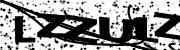

In [95]:
print(pred_list[137*6:137*6 + 6])
image = Image.open(f"dados/CAPTCHA-10k/teste/00"+str(138+9001)+".jpg").convert('L')
Image.fromarray(np.array(image), 'L')

['0', 'K', '6', 'O', 'Q', '0']


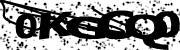

In [97]:
print(pred_list[140*6:140*6 + 6])
image = Image.open(f"dados/CAPTCHA-10k/teste/00"+str(141+9001)+".jpg").convert('L')
Image.fromarray(np.array(image), 'L')